**Introduction**

Machine Learning algorithms have become an increasingly important tool for analyzing the data from the Large Hadron Collider (LHC). Identification of particles in LHC collisions is an important task of LHC detector reconstruction algorithms.

Here we present a challenge where one of the detectors (the Electromagnetic Calorimeter or ECAL) is used as a camera to analyze detector images from two types of particles: electrons and photons that deposit their energy in this detector.

**Dataset**

Each pixel in the image corresponds to a detector cell, while the intensity of the pixel corresponds to how much energy is measured in that cell. Timing of the energy deposits are also available, though this may or may not be relevant. The dataset contains 32x32 Images of the energy hits and their timing (channel 1: hit energy and channel 2: its timing) in each calorimeter cell (one cell = one pixel) for the two classes of particles: Electrons and Photons. The dataset contains around four hundred thousand images for electrons and photons. Please note that your final model will be evaluated on an unseen test dataset.

**Algorithm**

Please use a Machine Learning model of your choice to achieve the highest possible classification performance on the provided dataset. Please provide a Jupyter Notebook that shows your solution.

Evaluation Metrics
ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)
Training and Validation Accuracy
The model performance will be tested on a hidden test dataset based on the above metrics.

**Deliverables**

Google Colab Jupyter Notebook showing your solution along with the final model accuracy (Training and Validation), ROC curve and AUC score. More details regarding the format of the notebook can be found in the sample Google Colab notebook provided for this challenge.
The final trained model including the model architecture and the trained weights ( For example: HDF5 file, .pb file, .pt file, etc. ). You are free to choose Machine Learning Framework of your choice.


## Create the appropriate project folder

In [ ]:
mkdir Particle_Images

In [ ]:
cd Particle_Images

/content/Particle_Images


In [ ]:
mkdir data

# Download the Dataset
This will download 83MB for SingleElectron and 76MB for SinglePhoton.

In [ ]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2024-04-02 02:44:29--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.142.170.17, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/sHjzCNFTFxutYCj/download [following]
--2024-04-02 02:44:31--  https://cernbox.cern.ch/s/sHjzCNFTFxutYCj/download
Reusing existing connection to cernbox.cern.ch:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron     [    <=>             ]  82.98M  13.7MB/s    in 7.8s    

2024-04-02 02:44:41 (10.6 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508]

--2024-04-02 02:44:41--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 128.1

# Import modules

In [ ]:
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all
import h5py
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Model Parameters

In [ ]:
lr_init     = 1e-4    # Initial learning rate
batch_size  = 64      # Training batch size
num_samples = 30000  # Maximum of 211599
train_size = int((0.8 * num_samples) // 1)
valid_size = int((0.1 * num_samples) // 1)
test_size = int((0.1 * num_samples) // 1) # Needs to be set to 42340 for final eval
num_epochs = 10

It is recommended to use GPU for training and inference if possible.

# Load Image Data
- Two classes of particles: electrons and photons
- 32x32 matrices (two channels - hit energy and time) for the two classes of particles electrons and photons impinging on a calorimeter (one calorimetric cell = one pixel).
- Note that although timing channel is provided, it may not necessarily help the performance of the model.

In [ ]:
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

# Configure Training / Validation / Test Sets

In [ ]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = train_stop, train_stop+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = valid_stop, valid_stop+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

X_train = np.moveaxis(X_train, 3, 1)
X_valid = np.moveaxis(X_valid, 3, 1)
X_test = np.moveaxis(X_test, 3, 1)

# Plot sample of training images
Note that although the timing channel is provided, it may not necessarily help the performance of the model.

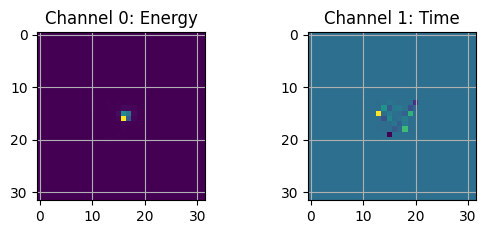

In [ ]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,0,:,:])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,1,:,:])
plt.title("Channel 1: Time")  # Time
plt.grid(True)


plt.show()

#Construct Dataloaders



In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.copy()).float()
        self.y = torch.from_numpy(y.copy()).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = ClassificationDataset(X_train, y_train)
valid_data = ClassificationDataset(X_valid, y_valid)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

In [ ]:
del X_train, y_train, X_valid, y_valid, X_test, y_test

# Define CNN Model

In [ ]:
### Define Convolutional Neural Network (CNN) Model ###

model = nn.Sequential()
model.append(nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, padding='same'))
model.append(nn.ReLU())
model.append(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'))
model.append(nn.ReLU())
model.append(nn. MaxPool2d(kernel_size=(2, 2)))
model.append(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'))
model.append(nn.ReLU())
model.append(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'))
model.append(nn.ReLU())
model.append(nn. MaxPool2d(kernel_size=(2, 2)))
model.append(nn.Flatten())
model.append(nn.Linear(1024, 256))
model.append(nn.ReLU())
model.append(nn.Dropout(0.2))
model.append(nn.Linear(256, 128))
model.append(nn.ReLU())
model.append(nn.Dropout(0.2))
model.append(nn.Linear(128, 1))
model.append(nn.Sigmoid())
model.append(nn.Flatten(start_dim=0))
print(model)

Sequential(
  (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): ReLU()
  (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=1024, out_features=256, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.2, inplace=False)
  (14): Linear(in_features=256, out_features=128, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.2, inplace=False)
  (17): Linear(in_features=128, out_features=1, bias=True)
  (18): Sigmoid()
  (19): Flatten(start_dim=0, end_dim=-1)
)


## Train the Model

In [ ]:
def train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric=None, scheduler=None, device='cpu'):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }  # Initialize a dictionary to store epoch-wise results

    model.to(device)  # Move the model to the specified device

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        X = X.to(device)
        y = y.to(device)
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            y = y.to(proper_dtype)
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, y)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                epoch_metric += metric(outputs, y)
            else:
                epoch_metric += 0.0

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                y_val = y_val.to(proper_dtype)
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, y_val).item()  # Compute loss
                if metric is not None:
                    val_metric += metric(outputs_val, y_val)
                else:
                    val_metric += 0.0

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

        if scheduler is not None:
            scheduler.step(val_loss)

    return history, model

In [ ]:
def test_model(model, data_loader, criterion, metric=None, device='cpu'):
    model.to(device)  # Move the model to the specified device

    model.eval()  # Set the model to evaluation mode

    total_loss = 0.0  # Initialize the total loss and metric values
    total_metric = 0.0

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(data_loader))
        X = X.to(device)
        y = y.to(device)
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")


    with torch.no_grad():  # Disable gradient tracking
        for batch in data_loader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y = y.to(proper_dtype)
            # Pass the data to the model and make predictions
            outputs = model(X)

            # Compute the loss
            loss = criterion(outputs, y)

            # Add the loss and metric for the batch to the total values
            total_loss += loss.item()

            if metric is not None:
                total_metric += metric(outputs, y)
            else:
                total_metric += 0.0

    # Average loss and metric for the entire dataset
    avg_loss = total_loss / len(data_loader)
    avg_metric = total_metric / len(data_loader)

    print(f'Test Loss: {avg_loss:.4f}, Test Metric: {avg_metric:.4f}')

    return avg_loss, avg_metric

In [ ]:
def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr_init)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2)
criterion = nn.BCELoss()
history, model = train_and_validate(train_loader, valid_loader, model, optimizer, criterion, num_epochs=num_epochs, metric=accuracy_metric, scheduler=scheduler, device=device)

Epoch [1/10], Train Loss: 0.6891, Train Metric: 0.5234, Val Loss: 0.6749, Val Metric: 0.5780
Epoch [2/10], Train Loss: 0.6682, Train Metric: 0.5895, Val Loss: 0.6634, Val Metric: 0.6023
Epoch [3/10], Train Loss: 0.6603, Train Metric: 0.6038, Val Loss: 0.6683, Val Metric: 0.5803
Epoch [4/10], Train Loss: 0.6576, Train Metric: 0.6095, Val Loss: 0.6599, Val Metric: 0.6046
Epoch [5/10], Train Loss: 0.6558, Train Metric: 0.6105, Val Loss: 0.6579, Val Metric: 0.6068
Epoch [6/10], Train Loss: 0.6545, Train Metric: 0.6128, Val Loss: 0.6571, Val Metric: 0.6094
Epoch [7/10], Train Loss: 0.6526, Train Metric: 0.6147, Val Loss: 0.6557, Val Metric: 0.6128
Epoch [8/10], Train Loss: 0.6513, Train Metric: 0.6181, Val Loss: 0.6544, Val Metric: 0.6125
Epoch [9/10], Train Loss: 0.6501, Train Metric: 0.6201, Val Loss: 0.6546, Val Metric: 0.6125
Epoch [10/10], Train Loss: 0.6485, Train Metric: 0.6228, Val Loss: 0.6532, Val Metric: 0.6112


## Evaluate the Model  
Along with the model accuracy, the prefered metric for evaluation is ROC (Receiver Operating Characteristic) curve and the AUC score (Area under the ROC Curve).

In [ ]:
# Evaluate on validation set
score = test_model(model, valid_loader, criterion, metric=accuracy_metric, device=device)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
# IF MODEL IS TOO LARGE THEN USE THE FOLLOWING TO KEEP THE MODEL ON GPU
# AND THE DATA ON CPU
model.to(device)
model.eval()
with torch.no_grad():
  y_pred = [model(x[0].to(device)).to('cpu').detach().numpy() for x in valid_loader]
labels = [x[1] for x in valid_loader]
y_pred = np.concatenate(y_pred, axis=0)
labels = np.concatenate(labels, axis=0)
fpr, tpr, _ = roc_curve(labels, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = test_model(model, test_loader, criterion, metric=accuracy_metric, device=device)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
# IF MODEL IS TOO LARGE THEN USE THE FOLLOWING TO KEEP THE MODEL ON GPU
# AND THE DATA ON CPU
model.to(device)
model.eval()
with torch.no_grad():
  y_pred = [model(x[0].to(device)).to('cpu').detach().numpy() for x in test_loader]
labels = [x[1] for x in test_loader]
y_pred = np.concatenate(y_pred, axis=0)
labels = np.concatenate(labels, axis=0)
fpr, tpr, _ = roc_curve(labels, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

Test Loss: 0.6532, Test Metric: 0.6112

Validation loss / accuracy: 0.6532 / 0.6112
Validation ROC AUC: 0.6567594444444445
Test Loss: 0.6488, Test Metric: 0.6181

Test loss / accuracy: 0.6488 / 0.6181
Test ROC AUC: 0.6594310000000001


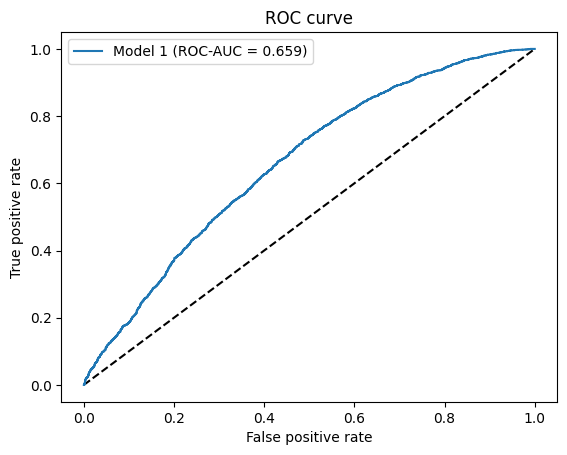

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Submission format:
Submit the Google Colab Jupyter Notebook demonstrating your solution in the similar format as illustrated in this notebook. It should contain:
*   The final model architecture, parameters and hyper-parameters yielding the best possible performance,
*   Its Training and Validation accuracy,
*   ROC curve and the AUC score as shown above.
*   Also, please submit the final trained model containing the model architecture and its trained weights along with this notebook (For example: HDF5 file, .pb file, .pt file, etc.). Either in this notebook or in a separate notebook show how to load and use your model.

Code for making a VGGNet was found here: https://blog.paperspace.com/vgg-from-scratch-pytorch/

In [ ]:
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all
import h5py
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size  = 64      # Training batch size
num_samples = 211599  # Maximum of 211599

train_size = int((0.8 * num_samples) // 1)
valid_size = int((0.1 * num_samples) // 1)
test_size = int((0.1 * num_samples) // 1) # Needs to be set to 211599 for final eval

In [ ]:
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

In [ ]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = train_stop, train_stop+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = valid_stop, valid_stop+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

X_train = np.moveaxis(X_train, 3, 1)
X_valid = np.moveaxis(X_valid, 3, 1)
X_test = np.moveaxis(X_test, 3, 1)

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.copy()).float()
        self.y = torch.from_numpy(y.copy()).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = ClassificationDataset(X_train, y_train)
valid_data = ClassificationDataset(X_valid, y_valid)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

In [ ]:
def train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric=None, scheduler=None, device='cpu'):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }  # Initialize a dictionary to store epoch-wise results

    model.to(device)  # Move the model to the specified device

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        X = X.to(device)
        y = y.to(device)
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            y = y.to(proper_dtype)
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, y)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                epoch_metric += metric(outputs, y)
            else:
                epoch_metric += 0.0

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                y_val = y_val.to(proper_dtype)
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, y_val).item()  # Compute loss
                if metric is not None:
                    val_metric += metric(outputs_val, y_val)
                else:
                    val_metric += 0.0

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

        if scheduler is not None:
            scheduler.step(val_loss)

    return history, model

In [ ]:
def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

# **The VGG16 Model**
Credit to Visual Geometry Group at University of Oxford for innovating this architecture. <br> <br>
This is our final model, achieving very strong ROC/AUC scores, due to the depth of the CNN used. However, this design is at the limits of our compute power, and careful hand-tuning of hyperparameters was required. Still, we expect the model as tuned to be a leading performer.

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2304, 2048),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 2048),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(2048, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Train/evaluate models:

As GPU runtime was limited, we were unable to be as thorough with hyperparamter tuning as we would of liked. Rather, values for learning rate, batch size, Adam epsilon, and scheduling factor were hand-selected for testing. Tested values and their corresponding ROC values can be seen below:

Learning rate:
.01 - 0.725 // .005 - 0.763 // .0025 -0.763 // .001 - 0.777 // .0005 - 0.752 // .0001 - 0.605

Batch size:
12 - 0.766 // 16 - 0.777 // 18 -0.777 // 20 - 0.775 // 32 - 0.763

Adam epsilon value:
0.1 - 0.617 // 0.01 - 0.746 // .001 - 0.777 // .0005 - 0.764 // .0001 - 0.781 // 0.00005 - 0.779 // 0.00001 - 0.771

Scheduling factor: 0.1 - 0.769 // 0.15 - 0.779 // 0.2 - 0.781 // 0.25 - 0.772 // 0.3 - 0.769


In [ ]:
num_classes = 2
num_epochs = 20
batch_size = 16
lr_init     = .001    # Initial learning rate


model = VGG16(num_classes).to(device)



optimizer = torch.optim.Adam(model.parameters(), lr=lr_init, eps=.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2)
criterion = nn.CrossEntropyLoss()

In [ ]:
history, model = train_and_validate(train_loader, valid_loader, model, optimizer, criterion, num_epochs=num_epochs, metric=accuracy_metric, scheduler=scheduler, device=device)

Epoch [1/30], Train Loss: 0.6314, Train Metric: 0.6520, Val Loss: 0.5864, Val Metric: 0.7023
Epoch [2/30], Train Loss: 0.5848, Train Metric: 0.7038, Val Loss: 0.5784, Val Metric: 0.7055
Epoch [3/30], Train Loss: 0.5711, Train Metric: 0.7137, Val Loss: 0.5639, Val Metric: 0.7207
Epoch [4/30], Train Loss: 0.5649, Train Metric: 0.7176, Val Loss: 0.5646, Val Metric: 0.7180
Epoch [5/30], Train Loss: 0.5596, Train Metric: 0.7217, Val Loss: 0.5566, Val Metric: 0.7218
Epoch [6/30], Train Loss: 0.5562, Train Metric: 0.7239, Val Loss: 0.5700, Val Metric: 0.7173
Epoch [7/30], Train Loss: 0.5535, Train Metric: 0.7259, Val Loss: 0.5639, Val Metric: 0.7196
Epoch [8/30], Train Loss: 0.5507, Train Metric: 0.7278, Val Loss: 0.5497, Val Metric: 0.7278
Epoch [9/30], Train Loss: 0.5485, Train Metric: 0.7292, Val Loss: 0.5520, Val Metric: 0.7273
Epoch [10/30], Train Loss: 0.5463, Train Metric: 0.7306, Val Loss: 0.5529, Val Metric: 0.7235
Epoch [11/30], Train Loss: 0.5454, Train Metric: 0.7312, Val Loss: 0.

In [ ]:
# Evaluate on validation set
score = test_model(model, valid_loader, criterion, metric=accuracy_metric, device=device)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
# IF MODEL IS TOO LARGE THEN USE THE FOLLOWING TO KEEP THE MODEL ON GPU
# AND THE DATA ON CPU
model.to(device)
model.eval()
with torch.no_grad():
  y_pred = [model(x[0].to(device)).to('cpu').detach().numpy() for x in valid_loader]
labels = [x[1] for x in valid_loader]
y_pred = np.concatenate(y_pred, axis=0)
labels = np.concatenate(labels, axis=0)
fpr, tpr, _ = roc_curve(labels, y_pred[:,1])
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = test_model(model, test_loader, criterion, metric=accuracy_metric, device=device)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
# IF MODEL IS TOO LARGE THEN USE THE FOLLOWING TO KEEP THE MODEL ON GPU
# AND THE DATA ON CPU
model.to(device)
model.eval()
with torch.no_grad():
  y_pred = [model(x[0].to(device)).to('cpu').detach().numpy() for x in test_loader]
labels = [x[1] for x in test_loader]
y_pred = np.concatenate(y_pred, axis=0)
labels = np.concatenate(labels, axis=0)
fpr, tpr, _ = roc_curve(labels, y_pred[:,1])
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

Test Loss: 0.5320, Test Metric: 0.7398

Validation loss / accuracy: 0.5320 / 0.7398
Validation ROC AUC: 0.8101737990166751
Test Loss: 0.5294, Test Metric: 0.7436

Test loss / accuracy: 0.5294 / 0.7436
Test ROC AUC: 0.8116826409856039


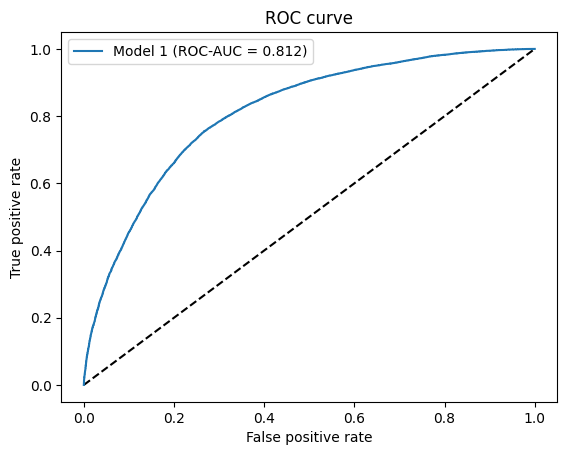

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Machine Learning/model.pth')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

newModel = VGG16(num_classes).to(device)
newModel.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Machine Learning/model.pth'))
model.eval()


Mounted at /content/drive


VGG16(
  (layer1): Sequential(
    (0): Conv2d(2, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False